In [1]:
import argparse
import numpy
import os

import utils
from utils import device

In [ ]:

# Parse arguments

parser = argparse.ArgumentParser()
parser.add_argument("--env", required=True,
                    help="name of the environment to be run (REQUIRED)")
parser.add_argument("--model", required=True,
                    help="name of the trained model (REQUIRED)")
parser.add_argument("--seed", type=int, default=0,
                    help="random seed (default: 0)")
parser.add_argument("--shift", type=int, default=0,
                    help="number of times the environment is reset at the beginning (default: 0)")
parser.add_argument("--argmax", action="store_true", default=False,
                    help="select the action with highest probability (default: False)")
parser.add_argument("--pause", type=float, default=0.1,
                    help="pause duration between two consequent actions of the agent (default: 0.1)")
parser.add_argument("--gif", type=str, default=None,
                    help="store output as gif with the given filename")
parser.add_argument("--episodes", type=int, default=1000000,
                    help="number of episodes to visualize")
parser.add_argument("--memory", action="store_true", default=False,
                    help="add a LSTM to the model")
parser.add_argument("--text", action="store_true", default=False,
                    help="add a GRU to the model")

args = parser.parse_args()

# Set seed for all randomness sources

utils.seed(args.seed)

# Set device

print(f"Device: {device}\n")

# Load environment
# env = utils.make_env(args.env, 100, args.seed, render_mode="human")
env = utils.make_env(args.env, args.seed, render_mode="human")
for _ in range(args.shift):
    env.reset()
print("Environment loaded\n")

# Load agent

model_dir = utils.get_model_dir(args.model)
agent = utils.Agent(env.observation_space, env.action_space, model_dir,
                    argmax=args.argmax, use_memory=args.memory, use_text=args.text)
print("Agent loaded\n")

# Run the agent

if args.gif:
    from array2gif import write_gif

    frames = []
    # gifs = []

# Create a window to view the environment
env.render()

for episode in range(args.episodes):
    obs, _ = env.reset()
    print(f'Episode[{episode}/{args.episodes}]----Goal: {env.realgoal}, Mission: {env.mission}')
    while True:
        # env.render()
        if args.gif:
            frames.append(numpy.moveaxis(env.get_frame(), 2, 0))

        action = agent.get_action(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated | truncated
        agent.analyze_feedback(reward, done)
        # print(action)
        if done:
            break
    # env.render()
    frames.append(numpy.moveaxis(env.get_frame(), 2, 0))
    if args.gif:
        print("Saving gif... ", end="")
        import time
        t = time.strftime("%m-%d-%H%M", time.localtime())
        gifdir = os.path.join(model_dir, 'visual_gif', t)
        if not os.path.exists(gifdir):
            os.makedirs(gifdir)
        write_gif(numpy.array(frames), os.path.join(gifdir, args.gif+str(episode)+".gif"), fps=1/args.pause)
        print("Done.")
    frames = []
    print('Done')



findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang
findfont: Generic family 'sa

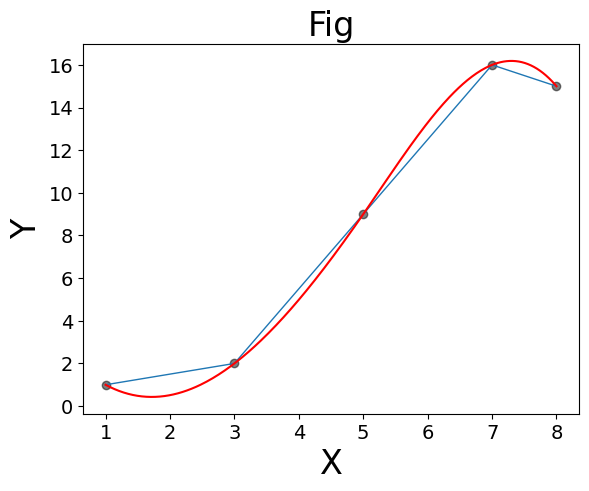

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
 
x = np.array([1, 3, 5, 7, 8])
y = np.array([1, 2, 9, 16, 15])
x_new = np.linspace(x.min(),x.max(),300) #300 represents number of points to make between T.min and T.max
y_smooth = make_interp_spline(x,y)(x_new)
#散点图
plt.scatter(x, y, c='black',alpha = 0.5)  #alpha:透明度) c:颜色
#折线图
plt.plot(x, y, linewidth=1)  #线宽linewidth=1
#平滑后的折线图
plt.plot(x_new,y_smooth,c='red')
 
# 解决中文显示问题
# plt.rcParams['font.sans-serif'] = ['PingFang']  #SimHei黑体
# plt.rcParams['axes.unicode_minus'] = False
 
plt.title("Fig", fontsize=24)#标题及字号
plt.xlabel("X", fontsize=24)#X轴标题及字号
plt.ylabel("Y", fontsize=24)#Y轴标题及字号
plt.tick_params(axis='both', labelsize=14)#刻度大小
#plt.axis([0, 1100, 1, 1100000])#设置坐标轴的取值范围
plt.show()

#plt.save('squares_plot.png'（文件名）, bbox_inches='tight'（将图表多余的空白部分剪掉）)
#用它替换plt.show实现自动保存图表

```python
COLORS = {
    "red": np.array([255, 0, 0]),
    "green": np.array([0, 255, 0]),
    "blue": np.array([0, 0, 255]),
    "purple": np.array([112, 39, 195]),
    "yellow": np.array([255, 255, 0]),
    "grey": np.array([100, 100, 100]),
}

COLOR_NAMES = sorted(list(COLORS.keys()))
```

In [2]:
from __future__ import annotations


from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall, Box, Ball
from minigrid.minigrid_env import MiniGridEnv
import itertools
import random

class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(9, 8),
        agent_start_dir=1,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        # self.grid.wall_rect(0, 0, width, height)

        # for i in range(width-4, width):
        #     self.grid.set(i, height-1, Wall())
        #     self.grid.set(i, height-2, Wall())

        # Place the door and key
        # self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        # self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # obj, _ = self.add_object(1, 0, kind="box")
        # door, pos = self.add_door(0, 0, 0, locked=True)
        # self.grid.set(pos[0] - 1, pos[1], Ball(color))
        # self.add_object(0, 0, "key", door.color)
        
        # Place a goal square in the bottom-right corner
        n_k1, n_k2 = 5, 5
        _pos = list(itertools.product(range(3, 10-2), range(0, 10-1)))
        pos = random.sample(_pos, n_k1 + n_k2)

        # self.put_obj(Ball((COLOR_NAMES[0])), 0, 0)
        # self.put_obj(Ball((COLOR_NAMES[0])), 2, 0)
        # self.put_obj(Ball((COLOR_NAMES[0])), 4, 0)

        for i in range(n_k1):
            self.put_obj(Box((COLOR_NAMES[1])), pos[i][1], pos[i][0])
        # self.put_obj(Box((COLOR_NAMES[1])), 4, 2)
        # self.put_obj(Box((COLOR_NAMES[1])), 6, 5)
        for i in range(n_k2):
            self.put_obj(Box((COLOR_NAMES[2])), pos[i+n_k1][1], pos[i+n_k2][0])
        # self.put_obj(Box((COLOR_NAMES[2])), 0, 6)
        # self.put_obj(Box((COLOR_NAMES[2])), 3, 7)

        # self.put_obj(Goal(), 3, 5)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            # self.place_agent()
            pass
        # self.place_agent()
        self.mission = "grand mission"

In [3]:
env = SimpleEnv(render_mode='human')
from array2gif import write_gif
import os
import numpy
frames = []

# Create a window to view the environment
# env.render()
env.reset()
frames.append(numpy.moveaxis(env.get_frame(), 2, 0))
# import time
# t = time.strftime("%m-%d", time.localtime())
t = 'trash-grid'
gifdir = os.path.join('./', 'visual_cus', t)
if not os.path.exists(gifdir):
    os.makedirs(gifdir)
write_gif(numpy.array(frames), os.path.join(gifdir, "sdf.gif"), fps=1/1)
print("Done.")
frames = []

# for episode in range(10):
#     obs, _ = env.reset()
#     while True:
#         # env.render()
#         frames.append(numpy.moveaxis(env.get_frame(), 2, 0))

#         action = agent.get_action(obs)
#         obs, reward, terminated, truncated, _ = env.step(action)
#         done = terminated | truncated
#         agent.analyze_feedback(reward, done)
#         # print(action)
#         if done:
#             break
#     # env.render()
#     frames.append(numpy.moveaxis(env.get_frame(), 2, 0))
#     if args.gif:
#         print("Saving gif... ", end="")
#         import time
#         t = time.strftime("%m-%d-%H%M", time.localtime())
#         gifdir = os.path.join(model_dir, 'visual_gif', t)
#         if not os.path.exists(gifdir):
#             os.makedirs(gifdir)
#         write_gif(numpy.array(frames), os.path.join(gifdir, args.gif+str(episode)+".gif"), fps=1/args.pause)
#         print("Done.")
#     frames = []

Done.


Bad pipe message: %s [b'v:1.8.1.6) Gecko/20070725 Firef']
Bad pipe message: %s [b'\x8a6\xc5\x88)\xdb\xbb.m\xba\x94\x91\x8b}#\x19\xed\xd0\x00\x00\x84\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\xc0"\xc0!\x00\xa3\x00\x9f\x00k\x00j\x009\x008\x00\x88\x00\x87\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\x00\x84\xc0\x12\xc0\x08\xc0\x1c\xc0\x1b\x00\x16\x00\x13\xc0\r\xc0\x03\x00\n\xc0/\xc0+\xc0\'\xc0#\xc0\x13\xc0\t\xc0\x1f\xc0\x1e\x00\xa2\x00\x9e\x00g\x00@\x003\x002\x00\x9a\x00\x99\x00E\x00D\xc01\xc0-\xc0)\xc0%\xc0\x0e\xc0\x04\x00\x9c\x00<\x00/\x00\x96\x00A\x00\x07\x00\xff\x01\x00\x01O\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x004\x002\x00\x0e\x00\r\x00\x19\x00\x0b\x00\x0c\x00\x18\x00\t\x00\n\x00\x16\x00\x17\x00\x08\x00\x06\x00\x07\x00\x14\x00\x15\x00\x04\x00\x05\x00\x12\x00\x13\x00\x01\x00\x02\x00\x03\x00\x0f\x00\x10\x00\x11\x00\r\x00 \x00\x1e\x06\x01\x06\x02\x06\x03\x05\x01\x05\x02\x05\x03', b'\x04\x02\x04', b'\x01\x03', b'\x03', b'\x02', b'\x03']
